# Introduction

In the realm of data science and analytics, understanding the causal relationships between variables is paramount. While traditional statistical methods have provided insights into these relationships, the advent of probabilistic programming has ushered in a new era of causal analysis. In this article, we will explore the power of counterfactuals in causal analysis using the PyMC framework, with a special focus on the “do-operator.”
Counterfactuals are essentially “what-if” scenarios that allow us to understand the potential outcomes had a different action been taken or a different condition been present. By leveraging the PyMC framework and its “do-operator,” we can programmatically simulate these scenarios, giving us a deeper understanding of the relationships between predictors and target variables.

Through a step-by-step guide, we will delve into the process of building a PyMC model skeleton, generating data using the do-operator, and validating the relationships captured by the model. Furthermore, we will explore the magic of the do-operator in simulating different ‘what-if’ scenarios, akin to programmatic A/B testing.

- Step 1. Build a pymc model skeleton
- Step 2. Use model skeleton and generate data using do-operator to infuse relationship between predictors and target variable (ssshhh, that’s a hidden superhero feature of do-operator ;) )
- Step 3. Use observe-operator to assign generated data on the model skeleton
- Step 4. Create samples and validate that the infused relationship between predictors and target variable are captured by the model samples (isn’t that what we expect a predictive model to do ;) )
- Step 5. Use do-operator to time travel, and generate target variable with different ‘what-if’ scenarios (basically mimic A/B testing…programatically)


## Import libraries

In [3]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import pymc_experimental as pmx
import seaborn as sns
from packaging import version
# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe
import warnings
warnings.filterwarnings('ignore')
from packaging import version

In [16]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

### Step 1. Build a pymc model skeleton

For this demo, we are building a very simple Linear Regression model.
- Predictor — ‘a’, ‘b’, ‘c’
- Target Variable — ‘y’
- Coefficients —
>- ‘beta_ay’ -> coefficient of |a|
>- ‘beta_by’ -> coefficient of |b|
>- ‘beta_cy’ -> coefficient of |c|

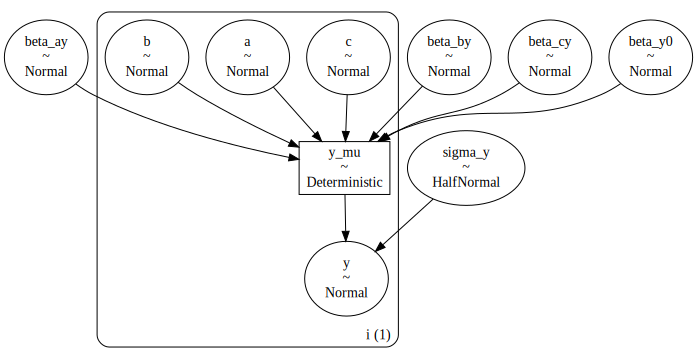

In [5]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors
    beta_y0 = pm.Normal("beta_y0")
    beta_ay = pm.Normal("beta_ay")
    beta_by = pm.Normal("beta_by")
    beta_cy = pm.Normal("beta_cy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    a = pm.Normal("a", mu=0, sigma=1, dims="i")
    b = pm.Normal("b", mu=0, sigma=1, dims="i")
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_ay * a) + (beta_by * b) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")


pm.model_to_graphviz(model_generative)

### Step 2. Use model skeleton and generate data using do-operator to infuse relationship between predictors and target variable. We will use this generated data for modelling later.

Let’s first define the predictors relationship with target variable.

In [6]:
true_values = {
    "beta_ay": 1.5,
    "beta_by": 0.7,
    "beta_cy": 0.3,
    "sigma_y": 0.2,
    "beta_y0": 0.0
}

Basically what we are saying here is, we are intentionally defining the coefficient values, which we expect predictive model to predict later on.

Now the magic begins. We will use do-operator to use this dictionary and sample data variables. How do we do this ? Simple by passing two arguments to pymc do-operator. First, the model skeleton object. And second, the coefficient dictionary.

In [7]:
model_simulate = do(model_generative, true_values)

This will create a new model object with the coefficent variables values infused. 

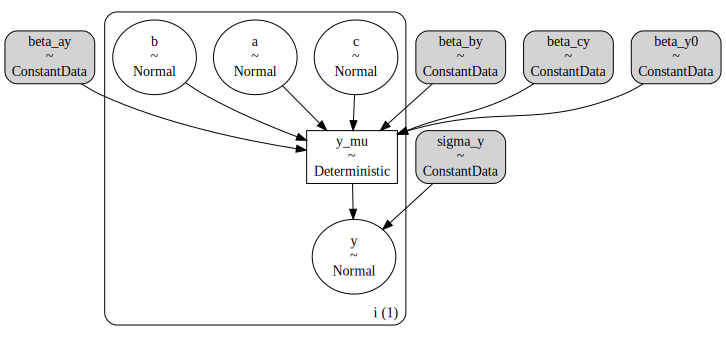

In [9]:
pm.model_to_graphviz(model_simulate)

The gray shades on the coefficient variables depicts the tale. Check the previous model graph, it was all white.

Now, all we have to do is generate samples, the known pymc way.

Lets generate 100 samples.

In [10]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N)

Sampling: [a, b, c, y]


We know that this generates an Arviz object, and since we have called sample_prior_predictive, hence the object will only contain priors.

In [11]:
simulate

Inference data with groups:
	> prior
	> constant_data

Extract the sampled prior data into a pandas dataframe.

In [12]:
observed = {
    "a": simulate.prior["a"].values.flatten(),
    "b": simulate.prior["b"].values.flatten(),
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten()
}

df = pd.DataFrame(observed)
print(df.shape)
df.head(5)

(100, 4)


,a,b,c,y
0,-0.387058,-0.601219,0.700782,-0.877544
1,-0.112285,-0.263738,0.360723,-0.497250
2,-0.221282,-1.262997,-1.264348,-1.500225
3,0.214622,-0.099602,0.294899,0.126182
4,0.636238,-0.370785,0.812118,1.158262


Ok, so now we are all set with a sample data.

Before we move to Step 3, just for fun, lets see if a simple Linear Regression model can extract these coefficients.

In [13]:
from sklearn.linear_model import LinearRegression
# Splitting data into predictors and target variable
X = df[['a', 'b', 'c']]
y = df['y']

# Building the linear regression model
model = LinearRegression()
model.fit(X, y)

# Getting the coefficients for each predictor
coefficients = model.coef_
coefficients

array([1.51334227, 0.72279028, 0.30879637])

Close enough ! Okay, lets not digress from the original topic. The pymc magic !

### Step 3. Use observe-operator to assign generated data on the model skeleton

Now, this is another cool feature of pymc newly introduced observe method. Observe method, takes in a model skeleton and the dictionary with the data for the variables we want to infuse into the model.

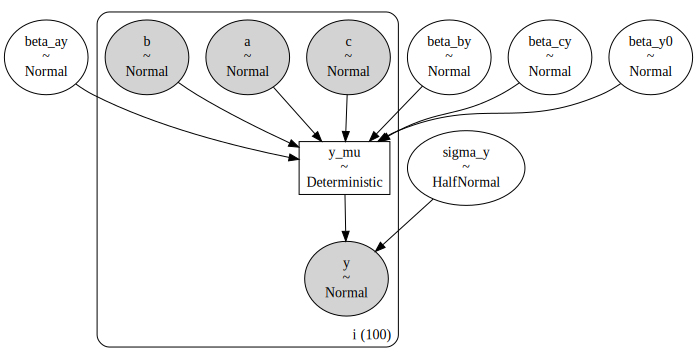

In [14]:
data_dict={"a": df["a"], 
           "b": df["b"], 
           "c": df["c"], 
           "y": df["y"]}
model_inference = observe(model_generative, data_dict)
model_inference.set_dim("i", N, coord_values=np.arange(N))
pm.model_to_graphviz(model_inference)

See the gray matter again. This time we have observed data infused into the model, and we have to sample for the coefficient and other parameters.

So, lets sample.

### Step 4. Create samples and validate that the infused relationship between predictors and target variable are captured by the model samples

In [17]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_ay, beta_by, beta_cy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


Now, lets validate if model captured the infused coefficient values in the data.

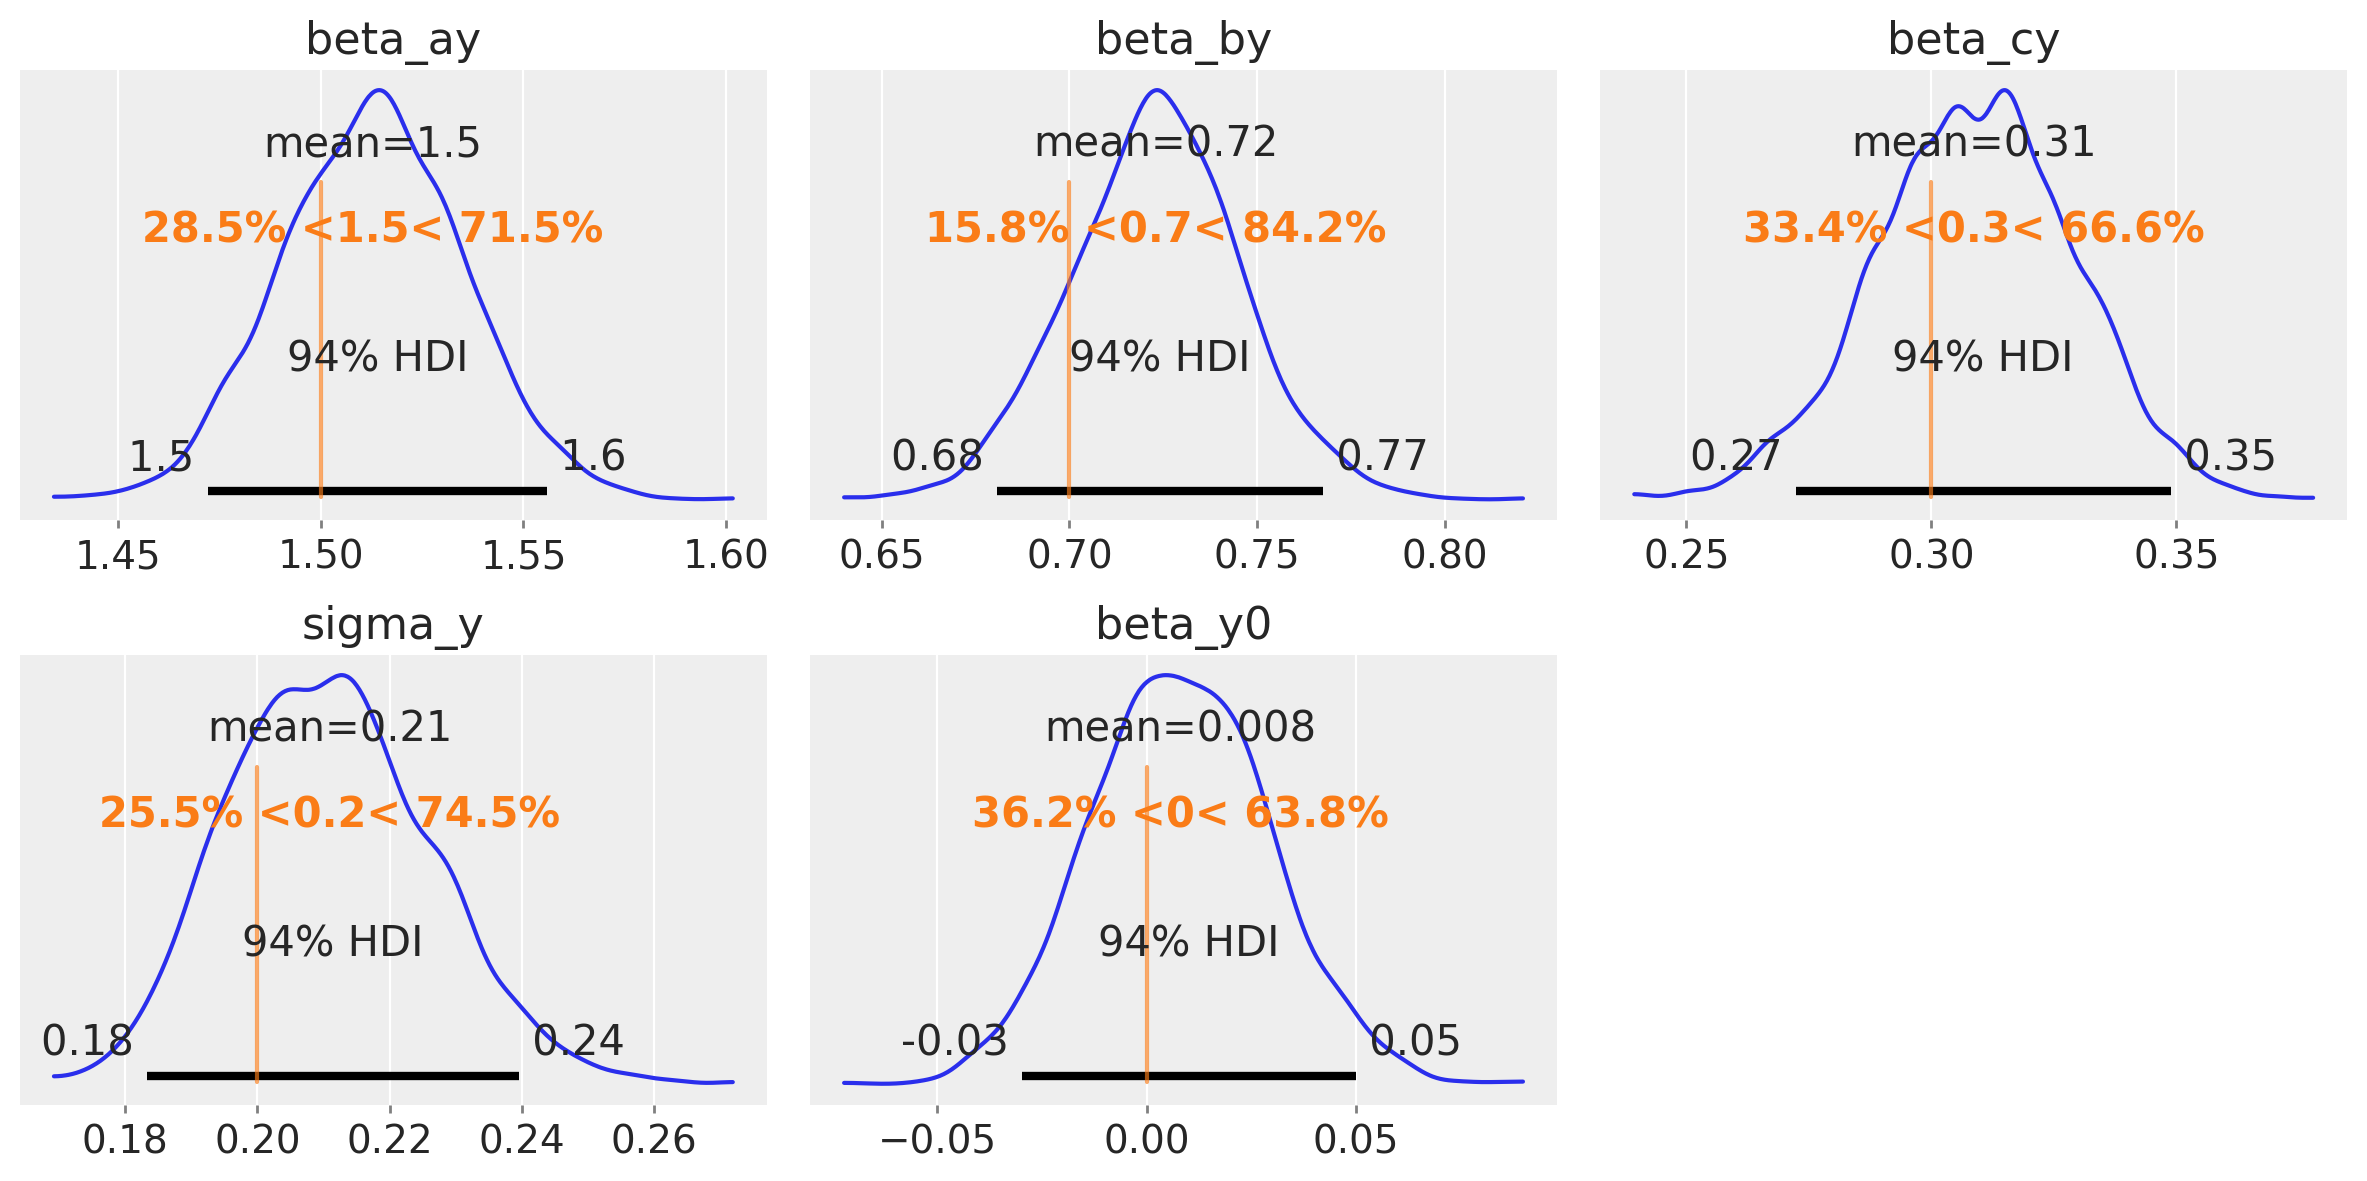

In [18]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

BAM ! Pretty nice fit !

Now, lets do what we are supposed to do ! Counterfactuals.

Basically, this is about generating target variable values with different predictor values. Basically, answering what if questions !

_What-if there was all ‘b’ values as 0 ?_

_What-if all ‘b’ values were double ?_

How to do this ? Here you go..

### Step 5. Use do-operator to time travel, and generate target variable with different ‘what-if’ scenarios.
Since, we want to experiment with ‘b’, lets first assign observed values to ‘a’ and ‘c’. Not to ‘y’, because that’s what we want to sample. Correct !

In [19]:
model_counterfactual = do(model_inference, {"a": df["a"], "c": df["c"]})

Now, lets begin the fun part. Let’s generate counterfactuals.

### _Scenario 1 :- What if all values for ‘b’ were 0 ?_

In [20]:
model_b0 = do(model_counterfactual, {"b": np.zeros(N, dtype="int32")}, prune_vars=True)
model_b1 = do(model_counterfactual, {"b": df["b"]}, prune_vars=True)

Just sample.

In [21]:
# Sample when 'b' was 0: P(y | (a,c), do(b=0))
idata_b0 = pm.sample_posterior_predictive(
    idata,
    model=model_b0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample when 'b' was as observed: P(y | (a,c), do(b=observed))
idata_b1 = pm.sample_posterior_predictive(
    idata,
    model=model_b1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

Sampling: []


Sampling: []


Some basic python and here we have the counterfactuals.

In [22]:
df["b_scenario_1"]=0
df["y_scenario_1"]=idata_b0.predictions.y_mu.mean(("chain", "draw")).values.reshape(1, -1).flatten()
df.head(5)

,a,b,c,y,b_scenario_1,y_scenario_1
0,-0.387058,-0.601219,0.700782,-0.877544,0,-0.361200
1,-0.112285,-0.263738,0.360723,-0.497250,0,-0.050510
2,-0.221282,-1.262997,-1.264348,-1.500225,0,-0.717104
3,0.214622,-0.099602,0.294899,0.126182,0,0.423711
4,0.636238,-0.370785,0.812118,1.158262,0,1.221210


### _Scenario 2: What if ‘b’ was 5 times as observed_

In [23]:
model_b0 = do(model_counterfactual, {"b": 5*df["b"]}, prune_vars=True)
model_b1 = do(model_counterfactual, {"b": df["b"]}, prune_vars=True)

Sample.

In [24]:
# Sample when 'b' was 5 times b: P(y | (a,c), do(b=5*b))
idata_b0 = pm.sample_posterior_predictive(
    idata,
    model=model_b0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample when 'b' was as observed: P(y | (a,c), do(b=observed))
idata_b1 = pm.sample_posterior_predictive(
    idata,
    model=model_b1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

df["b_scenario_2"]=5*df["b"]
df["y_scenario_2"]=idata_b0.predictions.y_mu.mean(("chain", "draw")).values.reshape(1, -1).flatten()
df.head(5)

Sampling: []


Sampling: []


,a,b,c,y,b_scenario_1,y_scenario_1,b_scenario_2,y_scenario_2
0,-0.387058,-0.601219,0.700782,-0.877544,0,-0.361200,-3.006096,-2.534414
1,-0.112285,-0.263738,0.360723,-0.497250,0,-0.050510,-1.318692,-1.003839
2,-0.221282,-1.262997,-1.264348,-1.500225,0,-0.717104,-6.314986,-5.282431
3,0.214622,-0.099602,0.294899,0.126182,0,0.423711,-0.498010,0.063683
4,0.636238,-0.370785,0.812118,1.158262,0,1.221210,-1.853923,-0.119057


Ok, so now you got the idea. It's an open playground. Go back in time, change whatever you want to change, and see how output changes.

This opens the door for many more possibilities in various use cases. Especially, Causal Analytics !